run this notebook with jupyter (anaconda3)

### import libraries

how to use Mlflow

In [12]:
import mlflow

In [78]:
import xgboost as xgb
from xgboost import XGBClassifier

### data processing

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import pickle

from tensorflow.keras.layers import Input, Dense, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from imblearn.under_sampling import RandomUnderSampler

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [3]:
data = pd.read_csv("playR_concattransformed_all.csv", index_col=0)
data.columns

Index(['KLF10', 'CD19', 'CD5', 'MYC', 'CD83', 'IgD', 'NR4A2', 'PPP1R15A',
       'JUND', 'FOSB', 'CD21', 'RGS1', 'CD27', 'KLF6', 'CD22', 'TCL1A',
       'DDIT3', 'Ki67', 'YPEL5', 'HSPA5', 'TXNIP', 'CD38', 'RGS2', 'EGR1',
       'IgM', 'CD69', 'FOS', 'CXCR4', 'Actin', 'labels'],
      dtype='object')

In [4]:
y_of_model = "labels"
drop_other_columns = ['MYC','Ki67','KLF10', 'JUND', 'FOSB',  'RGS1',  'KLF6',  'TCL1A', 'PPP1R15A',
                      'DDIT3', 'YPEL5', 'HSPA5', 'TXNIP', 'RGS2', 'EGR1','NR4A2',
                         'FOS', 'Actin', 'CD83',]
#drop_other_columns = ['MYC','Ki67']

y = data[y_of_model]
data = data.drop(y_of_model, axis = 1)

undersampler = RandomUnderSampler(random_state=42)
data, y = undersampler.fit_resample(data, y)


scaler = MinMaxScaler()
data2 = scaler.fit_transform(data)
data2 = pd.DataFrame(data2, columns = data.columns)
X = data.drop(drop_other_columns, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle = True, random_state=40)

In [5]:
with open("scaler_for_four_classifications.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [73]:
number_of_labels = len(list(set(y_train)))
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_encoded1 = label_encoder.transform(y_train)
y_encoded = to_categorical(y_encoded1)


y_encoded_test = label_encoder.transform(y_test)
#y_encoded_test = to_categorical(y_encoded_test)

In [74]:
label_codes = label_encoder.classes_
for code in label_codes:
    print(code)

Ki67+/Cmyc+
Ki67+/Cmyc-
Ki67-/Cmyc+
Ki67-/Cmyc-


### skip connection neural network

In [19]:
from tensorflow.keras.layers import Input, Dense, add

def dynamic_resnet(input_layer, num_units, num_blocks):
    x = input_layer
    x1 = input_layer
    for _ in range(num_blocks):
        x = Dense(units=num_units, activation='relu')(x)
        y = Dense(units=input_layer.shape[1], activation='relu')(x)
        x = add([y, x1])
        x1 = x
    return x1

inputs = Input(shape=(X_train.shape[1],))
output_first = dynamic_resnet(inputs, num_units=64, num_blocks=10)


In [20]:
outputs = Dense(units=number_of_labels, activation='sigmoid')(output_first)
model = Model(inputs=inputs, outputs=outputs)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_encoded, epochs=50, batch_size=100, verbose = 0)

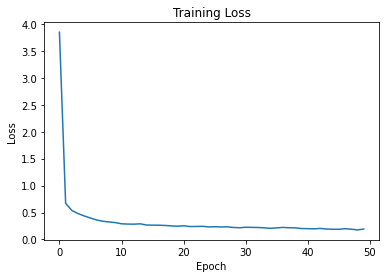

In [21]:
loss = history.history['loss']

# Plot the loss
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ['Cmyc', 'Ki67', 'Ki67_Cmyc', 'Others']
print(classification_report(y_encoded_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

        Cmyc       0.84      0.87      0.85       827
        Ki67       0.98      0.98      0.98       810
   Ki67_Cmyc       0.91      0.92      0.91       848
      Others       0.85      0.81      0.83       859

    accuracy                           0.89      3344
   macro avg       0.89      0.90      0.89      3344
weighted avg       0.89      0.89      0.89      3344



In [23]:
print(confusion_matrix(y_encoded_test, y_pred_classes))

[[718   9  27  73]
 [  8 797   2   3]
 [ 21   2 782  43]
 [106   6  53 694]]


In [ ]:
model.save("skip_connection_model_ki67_cmyc_4_classes.h5")

In [10]:
# inputs = Input(shape=(X_train.shape[1],))

# x = Dense(units=64, activation='relu')(inputs)
# w = Dense(units=64, activation='relu')(x)
# y = Dense(units=X_train.shape[1], activation='relu')(w)
# z = add([y, inputs])

# w = Dense(units=64, activation='relu')(z)
# y = Dense(units=X_train.shape[1], activation='relu')(w)
# z = add([y, z])

# outputs = Dense(units=number_of_labels, activation='sigmoid')(z)
# model = Model(inputs=inputs, outputs=outputs)
# lr = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
# history = model.fit(X_train, y_encoded, epochs=50, batch_size=100, verbose = 0)

In [30]:
# loss = history.history['loss']

# # Plot the loss
# plt.plot(loss)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [31]:
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# class_names = ['Cmyc', 'Ki67', 'Ki67_Cmyc', 'Others']
# print(classification_report(y_encoded_test, y_pred_classes, target_names=class_names))
# print(confusion_matrix(y_encoded_test, y_pred_classes))

### random forest

In [8]:
X_train = X_train.reset_index(drop=True)
np_x_train = np.array(X_train)

In [9]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

In [10]:
#mlflow.set_tracking_uri("sqlite:///mlruns.db")

In [13]:
rf = RandomForestClassifier()

# Create GridSearchCV object with autologging enabled
with mlflow.start_run() as run:
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
    
    # Enable autologging
    mlflow.sklearn.autolog()
    
    # Fit the model and perform grid search
    grid_search.fit(np_x_train, y_encoded)
    
    # Log best parameters and score
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metrics({'best_score': grid_search.best_score_})
    mlflow.log_metrics({'best_score': grid_search.best_score_})
    #mlflow.log_artifacts("mlflow_runs_artefacts")
    mlflow.sklearn.log_model(rf, "model")

2023/10/28 11:57:27 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3. Estimator expected <= 2.
2023/10/28 11:57:27 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc_score will not be recorded. Metric error: Found array with dim 3. Estimator expected <= 2.
2023/10/28 11:57:27 WARNING mlflow.sklearn.utils: Failed to autolog artifacts for GridSearchCV. Logging error: unhashable type: 'numpy.ndarray'
2023/10/28 11:57:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 283 runs will be omitted.


######  feature importance

In [21]:

rf = RandomForestClassifier()

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_encoded)


2023/10/14 16:42:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db6d23bb9eeb4cff819e0b9318ae5e90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/14 16:50:27 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3. Estimator expected <= 2.
2023/10/14 16:50:27 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc_score will not be recorded. Metric error: Found array with dim 3. Estimator expected <= 2.
2023/10/14 16:50:27 WARNING mlflow.sklearn.utils: Failed to autolog artifacts for GridSearchCV. Logging error: unhashable type: 'numpy.ndarray'
2023/10/14 16:50:38 INFO mlflow.sklearn.utils: Logging the 5 best runs, 283 runs will be omitted.


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [10, 20, 30, 40, 50, 60]})

In [62]:
# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score:  0.8762001755078052


In [63]:
best_model = grid_search.best_estimator_
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

In [64]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_encoded_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       827
           1       0.99      0.97      0.98       810
           2       0.95      0.87      0.91       848
           3       0.87      0.80      0.83       859

    accuracy                           0.89      3344
   macro avg       0.89      0.89      0.89      3344
weighted avg       0.89      0.89      0.89      3344



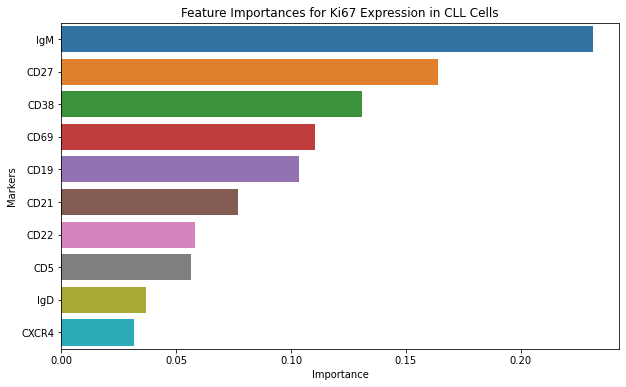

In [65]:
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importances for Ki67 Expression in CLL Cells')
plt.xlabel('Importance')
plt.ylabel('Markers')
plt.show()

In [66]:
file_path = 'best_random_forest_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
# creates database
# import sqlite3
# sqlite3.connect('mlruns')

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

### XGBoost

In [79]:
model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,
    objective='binary:logistic',  # For classification problems
    num_class=4
)

In [80]:
model.fit(X_train, y_encoded1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
y_pred = model.predict(X_test)

print(classification_report(y_encoded_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Cmyc       0.85      0.89      0.87       827
        Ki67       0.98      0.98      0.98       810
   Ki67_Cmyc       0.91      0.90      0.91       848
      Others       0.85      0.83      0.84       859

    accuracy                           0.90      3344
   macro avg       0.90      0.90      0.90      3344
weighted avg       0.90      0.90      0.90      3344



### Using KNN

In [47]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

In [48]:
knn.fit(X_train, y_encoded1)

2023/10/28 20:10:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '51552dd4f3eb405c9876a2e3605e2ade', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


KNeighborsClassifier(n_neighbors=3)

In [50]:
class_names = ['Cmyc', 'Ki67', 'Ki67_Cmyc', 'Others']

In [51]:
y_pred = knn.predict(X_test)

print(classification_report(y_encoded_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Cmyc       0.84      0.86      0.85       827
        Ki67       0.97      0.98      0.98       810
   Ki67_Cmyc       0.92      0.89      0.90       848
      Others       0.82      0.82      0.82       859

    accuracy                           0.89      3344
   macro avg       0.89      0.89      0.89      3344
weighted avg       0.89      0.89      0.89      3344



### SHAP experiment  
### for the xgboost model

In [1]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [82]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

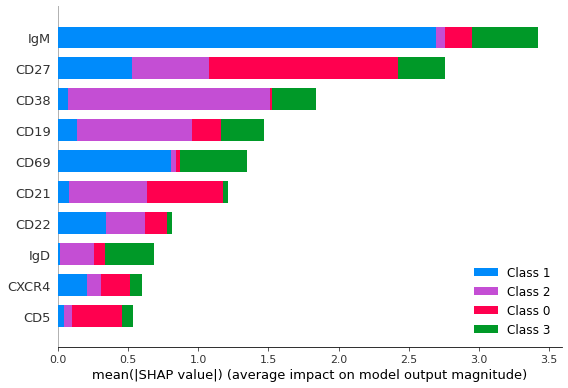

In [83]:
shap.summary_plot(shap_values, X_test)

In [84]:
# Ki67+/Cmyc+
# Ki67+/Cmyc-
# Ki67-/Cmyc+
# Ki67-/Cmyc-

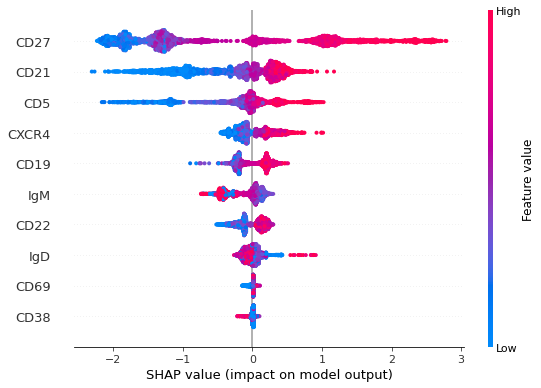

In [85]:
shap.summary_plot(shap_values[0], X_test)